# Goal

Using ML algorithms such as transfer learing and Open CV Computer Vision to identify the objects in the video and build KPI metrics

## Steps:
1. Install and Import Dependencies
2. Data Handling
3. Training with KPI metrics
4. Validate with KPI metrics
5. Inference with KPI metrics

## 1. Install and Import Dependencies

In [2]:
#!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

/home/srinu/video-analytics/yolov5
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
from yolov5 import utils
import torch
import utils
from IPython import display
from IPython.display import clear_output
from pathlib import Path
import yaml
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import numpy as np
import cv2


%matplotlib inline
display = utils.notebook_init()

YOLOv5 🚀 v6.1-72-gee77632 torch 1.11.0 CPU


Setup complete ✅ (12 CPUs, 62.5 GB RAM, 635.2/1828.6 GB disk)


# 2. Data Handling

In [3]:
def create_data_directories(data_name):
    Path(f"../datasets/{data_name}/images/train").mkdir(parents=True, exist_ok=True)
    Path(f"../datasets/{data_name}/images/valid").mkdir(parents=True, exist_ok=True)
    Path(f"../datasets/{data_name}/images/test").mkdir(parents=True, exist_ok=True)
    Path(f"../datasets/{data_name}/labels/train").mkdir(parents=True, exist_ok=True)
    Path(f"../datasets/{data_name}/labels/valid").mkdir(parents=True, exist_ok=True)
    Path(f"../datasets/{data_name}/labels/test").mkdir(parents=True, exist_ok=True)

    
create_data_directories('Peoples_data')

# 3. Training

## Feature extraction

In [4]:
# Weights & Biases  (optional)
#%pip install -q wandb
import wandb
wandb.login()

wandb: Currently logged in as: srikaku (use `wandb login --relogin` to force relogin)


True

In [5]:
!python3 train.py --batch 32 --epochs 299 --data 'data/coco128.yaml' --weights 'yolov5s6.pt' --project 'runs_peoples' --name 'feature_extraction' --cache --freeze 12
clear_output()

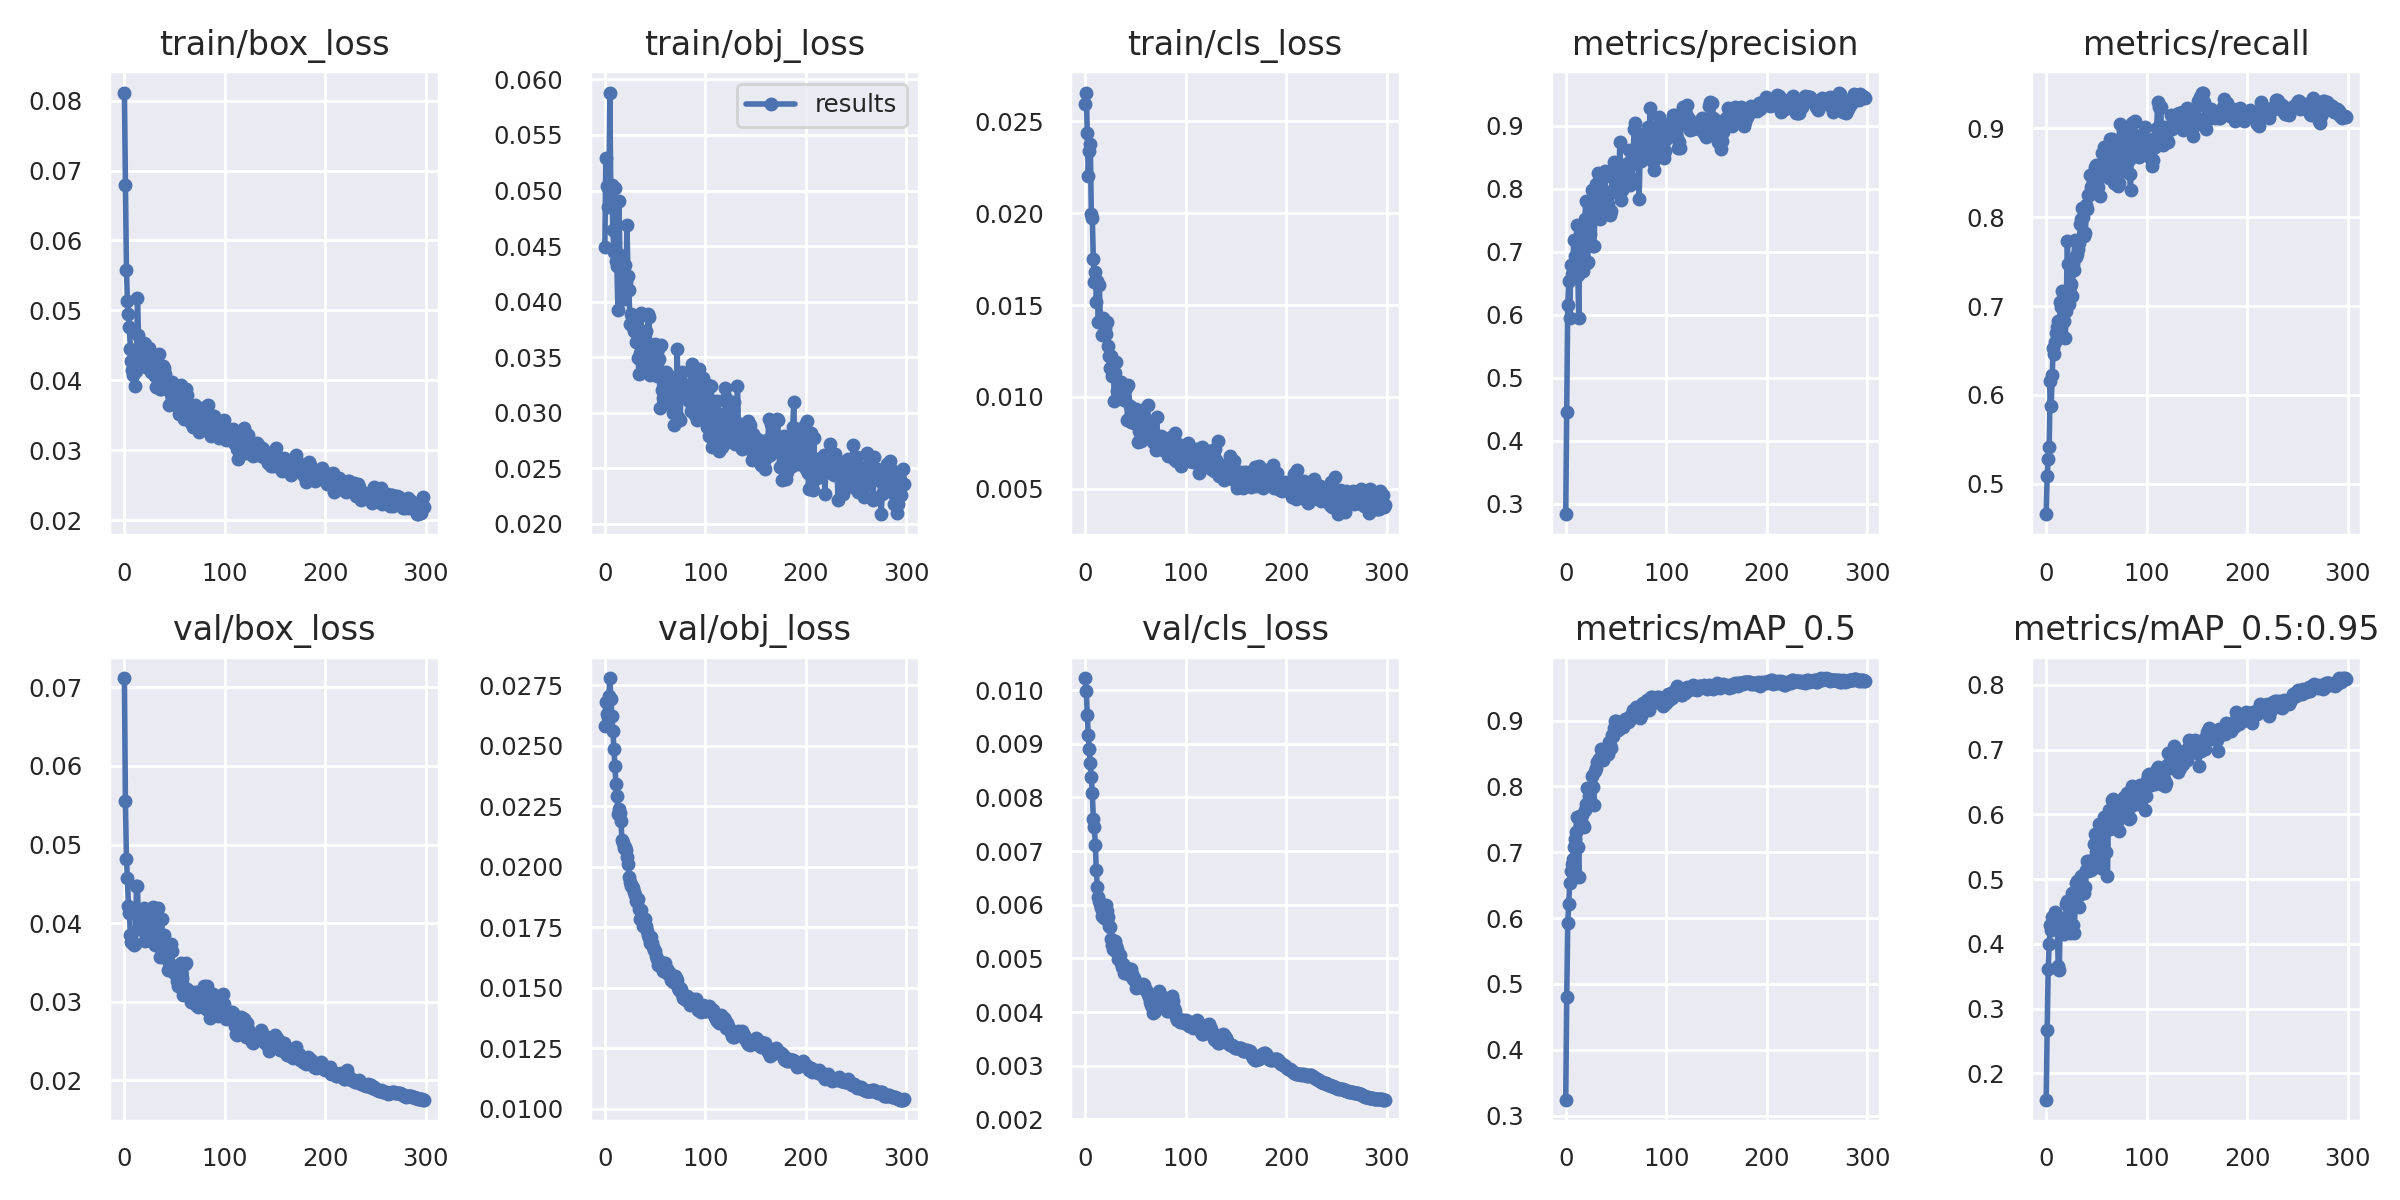

In [6]:
display.Image(f"runs_peoples/feature_extraction/results.png")

To better understand the results, let’s summarize YOLOv5 losses and metrics. YOLO loss function is composed of three parts:
1. ### box_loss — bounding box regression loss (Mean Squared Error).
2. ### obj_loss — the confidence of object presence is the objectness loss (Binary Cross Entropy).
3. ### cls_loss — the classification loss (Cross Entropy).

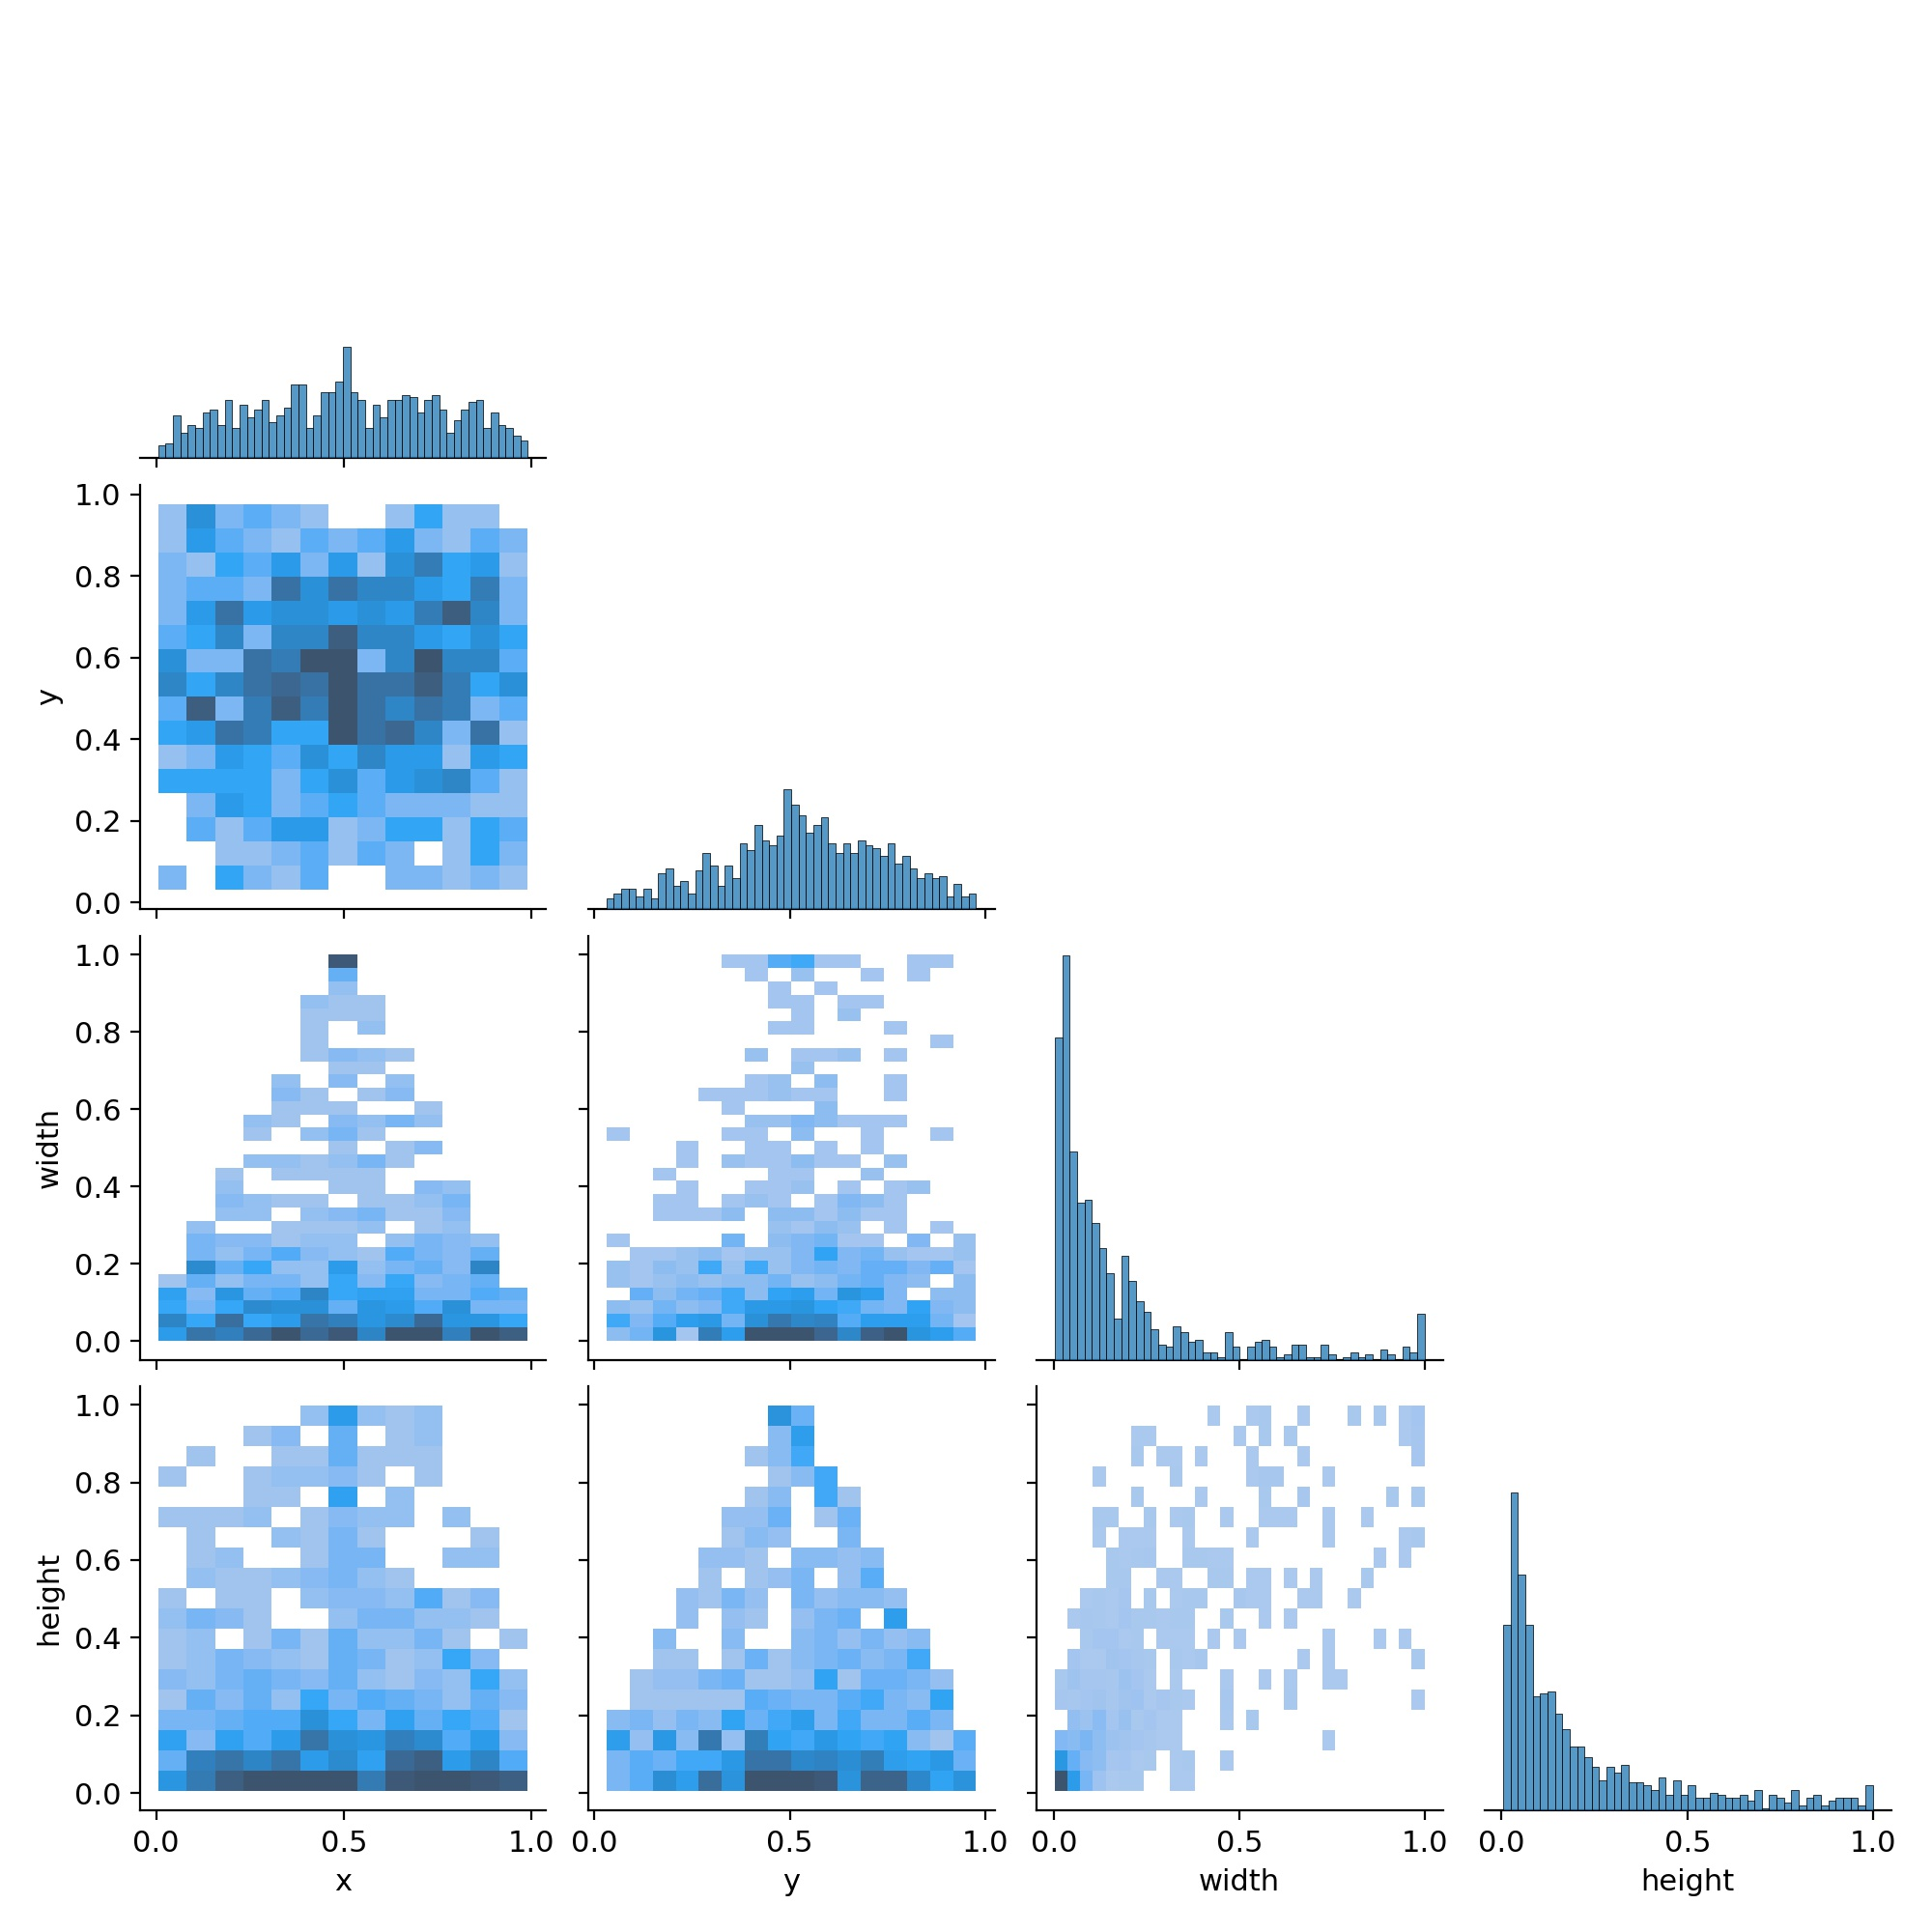

In [7]:
display.Image(f"runs_peoples/feature_extraction/labels_correlogram.jpg")

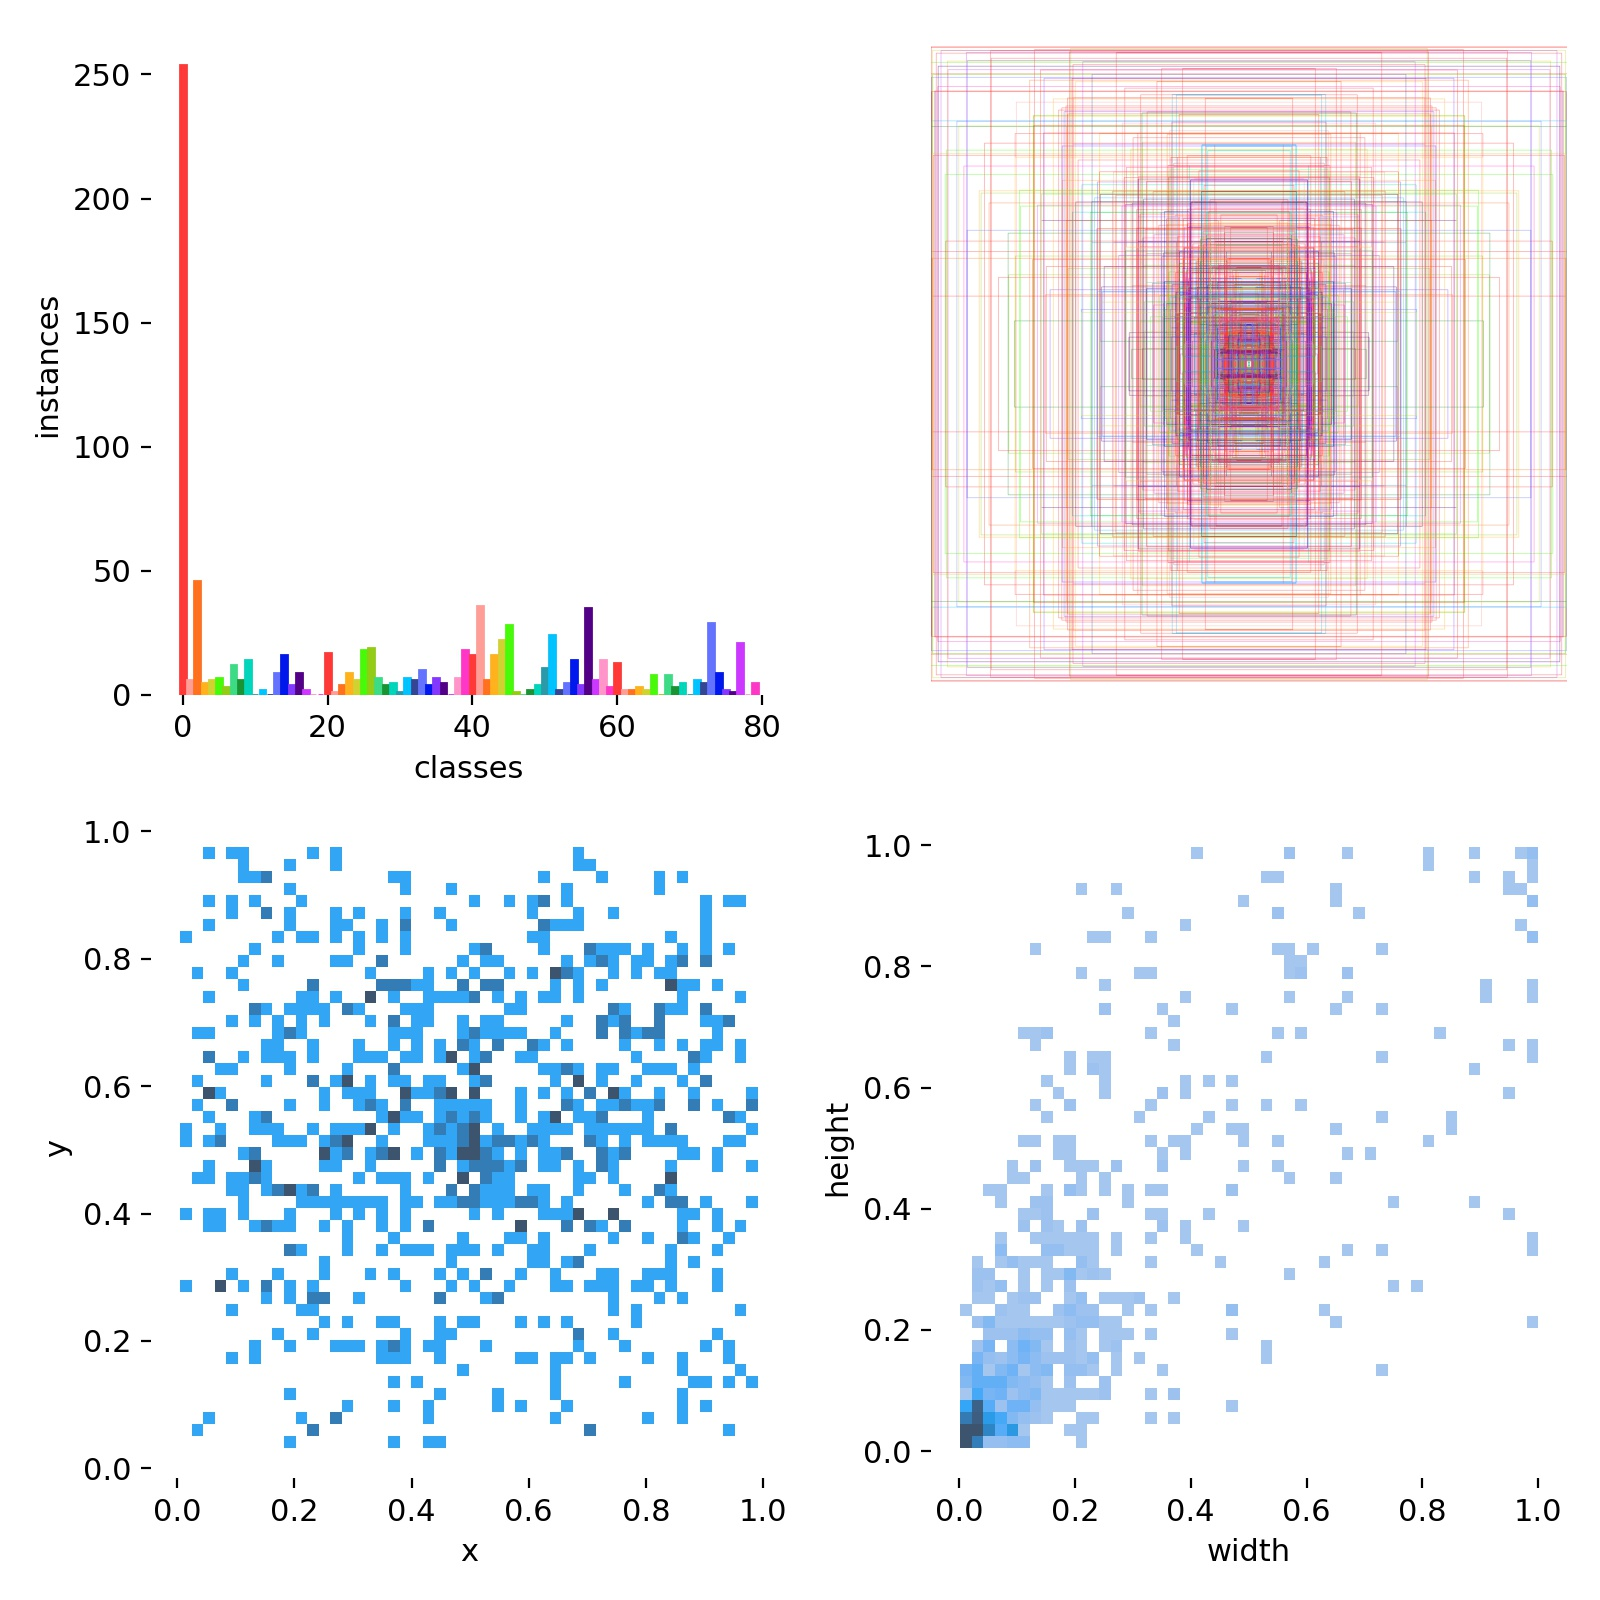

In [17]:
display.Image(f"runs_peoples/feature_extraction/labels.jpg")

# 4. Validate

In [34]:
# Download COCO val
torch.hub.download_url_to_file('https://ultralytics.com/assets/coco2017val.zip', 'tmp.zip')
!unzip -q tmp.zip -d ../datasets && rm tmp.zip

  0%|          | 0.00/780M [00:00<?, ?B/s]

In [18]:
!python val.py --weights 'runs_peoples/feature_extraction/weights/best.pt' --batch 64 --data coco.yaml --img 640 --iou 0.65 --half
clear_output()

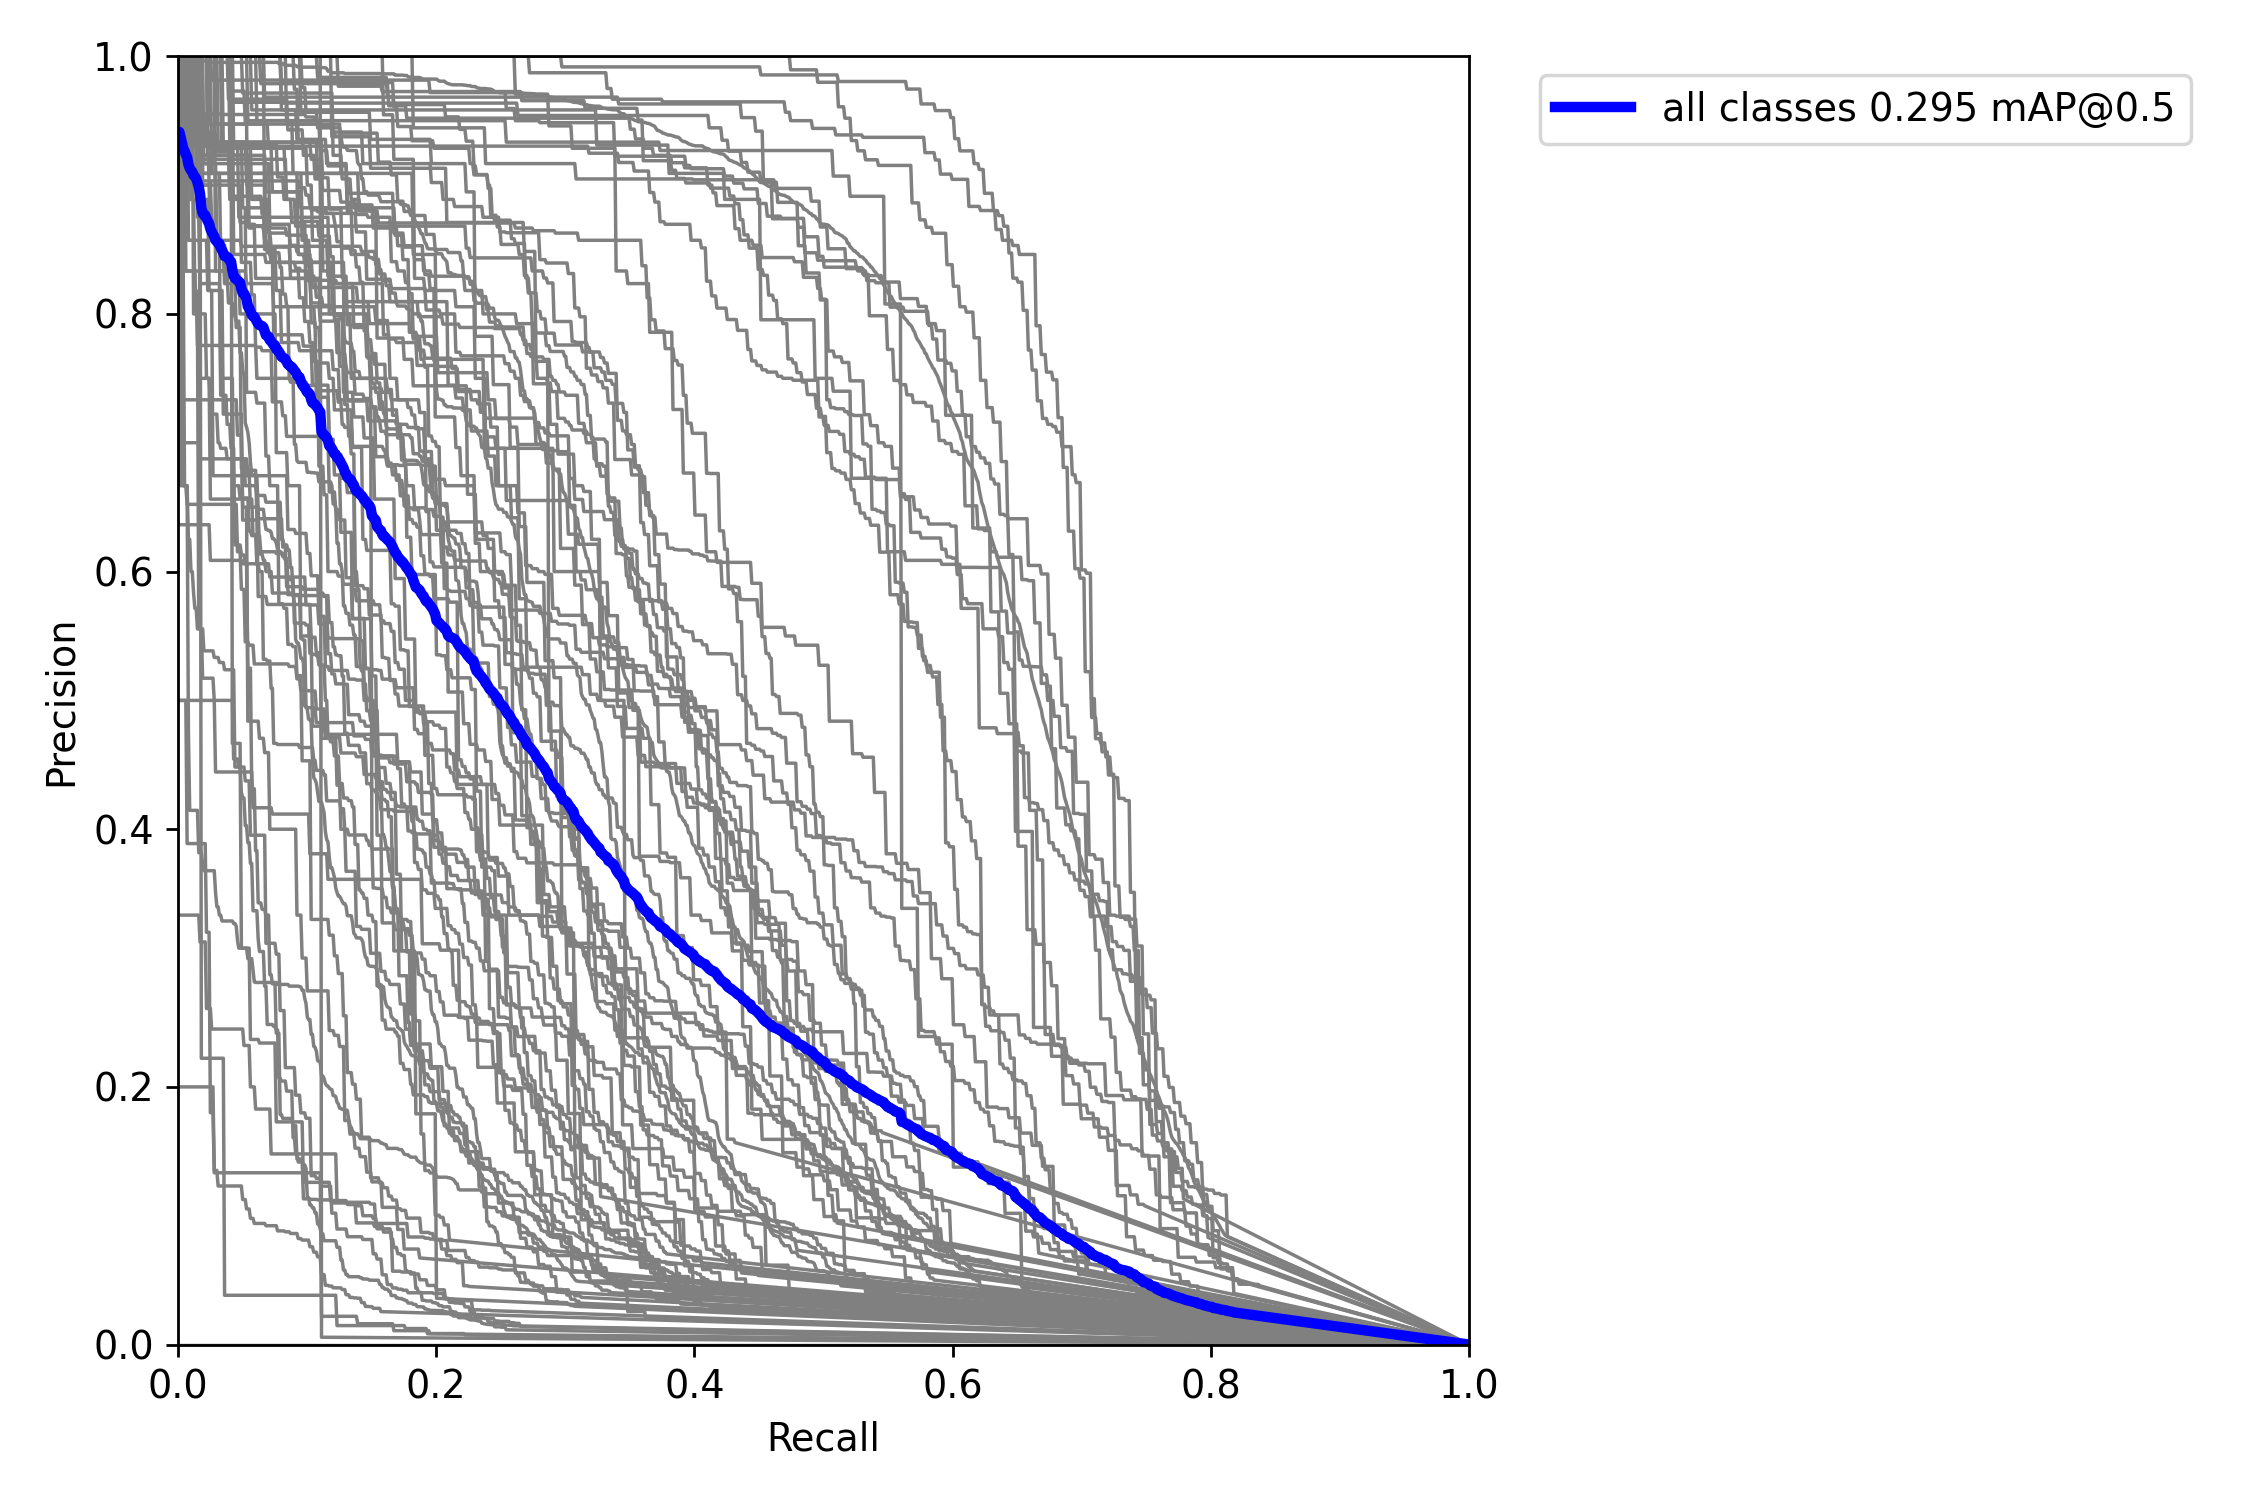

In [17]:
display.Image(f"runs/val/exp/PR_curve.png")

# 4. Inference and Test

Once we obtained satisfying training performances, our model is ready for inference. Upon inference, we can further boost the predictions accuracy by applying test-time augmentations (TTA): each image is being augmented (horizontal flip and 3 different resolutions), and the final prediction is an ensemble of all these augmentation. If we’re tight on the Frames-Per-Second (FPS) rate, we’ll have to ditch the TTA since the inference with it is 2–3 times longer.

The input for inference can be an image, a video, a directory, a webcam, a stream or even a youtube link. In the following detection command the test data is used for inference.

* source — input path (0 for webcam)
* weights — weights path
* img — image size for inference, in pixels
* conf — confidence threshold
* iou — IoU threshold for NMS (Non Max Supression)
* augment — augmented inference (TTA)

In [6]:
# Detect only people
!python detect.py --weights 'runs_peoples/feature_extraction/weights/best.pt' --img 640 --conf 0.25 --classes 0 --source ../data/VIRAT_S_000006.mp4
clear_output()

Inference results are automatically saved to the defined folder. Let’s review a sample of the test predictions:

In [20]:
import cv2

cap = cv2.VideoCapture('runs/detect/exp5/VIRAT_S_000006.mp4')


w = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
h = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
fps = cap.get(cv2.CAP_PROP_FPS) 
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output.mp4', fourcc, fps, (int(w),int(h)))

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret==True:
        #frame = cv2.flip(frame,0)

        # write the flipped frame
        out.write(frame)

        cv2.imshow('frame',frame)
        k = cv2.waitKey(60)
        #press escape key to quit
        if k == 27:
            break
    else:
        break

# Release everything if job is finished
cap.release()
out.release()
cv2.destroyAllWindows()
clear_output()